In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import itertools

In [4]:
dataset = pd.read_csv('/content/drive/MyDrive/drug200.csv')
dataset.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [5]:
from sklearn.preprocessing import LabelEncoder

# Copy the original dataframe
data = dataset.copy()

# Encode categorical features
label_encoders = {}
for column in ['Sex', 'BP', 'Cholesterol', 'Drug']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

print(data.head())

   Age  Sex  BP  Cholesterol  Na_to_K  Drug
0   23    0   0            0   25.355     4
1   47    1   1            0   13.093     2
2   47    1   1            0   10.114     2
3   28    0   2            0    7.798     3
4   61    0   1            0   18.043     4


In [6]:
def entropy(y):
  if isinstance(y, pd.Series):
    a = y.value_counts()/y.shape[0]
    entropy = np.sum(-a*np.log2(a+1e-9))
    return(entropy)
  else:
    raise('Object must be a Pandas Series.')
entropy(data["Drug"])


np.float64(1.9687803707401494)

In [7]:
def variance(y):
  if(len(y) == 1):
    return 0
  else:
    return y.var()

def information_gain(y, mask, func=entropy):
  a = sum(mask)
  b = mask.shape[0] - a

  if(a == 0 or b ==0):
    gain = 0
  else:
    if y.dtypes != 'O':
      gain = variance(y) - (a/(a+b)* variance(y[mask])) - (b/(a+b)*variance(y[-mask]))
    else:
      gain = func(y)-a/(a+b)*func(y[mask])-b/(a+b)*func(y[-mask])

  return gain

In [18]:
information_gain(data['Drug'], data['Na_to_K'] > 15)

1.0679755257770367

In [13]:
information_gain(data['Drug'], data['BP'] == 2)

0.10920468104067238

In [14]:
information_gain(data['Drug'], data['Age'] > 50)

-0.002388230836721128

In [15]:
information_gain(data['Drug'], data['Cholesterol'] == 1)

-0.003633270519259324

To calculate the best split of a numeric variable, first, all possible values that the variable is taking must be obtained. Once we have the options, for each option we will calculate the Information Gain using as a filter if the value is less than that value. Obviously, the first possible data will be drop, because the split will include all values.

In case we have categorical variables, the idea is the same, only that in this case we will have to calculate the Information Gain for all possible combinations of that variable, excluding the option that includes all the options (since it would not be doing any split). This is quite computationally costly if we have a high number of categories, that decision tree algorithms usually only accept categorical variables with less than 20 categories.

So, once we have all the splits, we will stick with the split that generates the highest Information Gain.

In [9]:
def categorical_options(a):
  #Creates all possible combinations from a Pandas Series.

  a = a.unique()

  opciones = []
  for L in range(0, len(a)+1):
      for subset in itertools.combinations(a, L):
          subset = list(subset)
          opciones.append(subset)

  return opciones[1:-1]

def max_information_gain_split(x, y, func=entropy):

  split_value = []
  gain = []

  numeric_variable = True if x.dtypes != 'O' else False

  if numeric_variable:
    options = x.sort_values().unique()[1:]
  else:
    options = categorical_options(x)

  # Calculate gain for all values
  for val in options:
    mask =   x < val if numeric_variable else x.isin(val)
    val_gain = information_gain(y, mask, func)
    # Append results
    gain.append(val_gain)
    split_value.append(val)

  if len(gain) == 0:
    return(None,None,None,False)

  else:
    best_gain = max(gain)
    best_gain_index = gain.index(best_gain)
    best_split = split_value[best_gain_index]
    return(best_gain,best_split,numeric_variable, True)

info_gain, NatoK_split, _, _ = max_information_gain_split(dataset['Na_to_K'], dataset['Drug'],)

print(
  "The best split for NatoK is when the variable is greater than ",
  NatoK_split,"\nInformation Gain for that split is:", info_gain)

The best split for NatoK is when the variable is greater than  15.015 
Information Gain for that split is: 0.994149168068919


best split will be the one that generates the highest Information Gain. To know which one is it, we simply have to calculate the Information Gain for each of the predictor variables of the model.

In [19]:
dataset.drop('Drug', axis= 1).apply(max_information_gain_split, y = dataset['Drug'])

,Age,Sex,BP,Cholesterol,Na_to_K
0,0.195407,0.007703,0.515456,0.093106,0.994149
1,51,[F],"[LOW, NORMAL]",[NORMAL],15.015
2,True,False,False,False,True
3,True,True,True,True,True


For Training

In [10]:
def get_best_split(y, dataset):
  masks = dataset.drop(y, axis= 1).apply(max_information_gain_split, y = dataset[y])
  if sum(masks.loc[3,:]) == 0:
    return(None, None, None, None)

  else:
    # Get only masks that can be splitted
    masks = masks.loc[:,masks.loc[3,:]]

    # Get the results for split with highest IG
    split_variable = masks.iloc[0].astype(np.float32).idxmax()
    #split_valid = masks[split_variable][]
    split_value = masks[split_variable][1]
    split_gain = masks[split_variable][0]
    split_numeric = masks[split_variable][2]

    return(split_variable, split_value, split_gain, split_numeric)


def make_split(variable, value, dataset, is_numeric):
  if is_numeric:
    dataset_1 = dataset[dataset[variable] < value]
    dataset_2 = dataset[(dataset[variable] < value) == False]
  else:
    dataset_1 = dataset[dataset[variable].isin(value)]
    dataset_2 = dataset[(dataset[variable].isin(value)) == False]

  return(dataset_1,dataset_2)


def make_prediction(dataset, target_factor):
  if target_factor:
    pred = dataset.value_counts().idxmax()
  else:
    pred = dataset.mean()

  return pred

In [11]:
def train_tree(dataset,y, target_factor, max_depth = None,min_samples_split = None, min_information_gain = 1e-20, counter=0, max_categories = 20):

  if counter==0:
    types = dataset.dtypes
    check_columns = types[types == "object"].index
    for column in check_columns:
      var_length = len(dataset[column].value_counts())
      if var_length > max_categories:
        raise ValueError('The variable ' + column + ' has '+ str(var_length) + ' unique values, which is more than the accepted ones: ' +  str(max_categories))

  if max_depth == None:
    depth_cond = True

  else:
    if counter < max_depth:
      depth_cond = True

    else:
      depth_cond = False

  if min_samples_split == None:
    sample_cond = True

  else:
    if dataset.shape[0] > min_samples_split:
      sample_cond = True

    else:
      sample_cond = False

  if depth_cond & sample_cond:
    var,val,gain,var_type = get_best_split(y, dataset)

    if gain is not None and gain >= min_information_gain:
      counter += 1
      left,right = make_split(var, val, dataset,var_type)

      # Instantiate sub-tree
      split_type = "<=" if var_type else "in"
      question =   "{} {}  {}".format(var,split_type,val)
      # question = "\n" + counter*" " + "|->" + var + " " + split_type + " " + str(val)
      subtree = {question: []}

      # Find answers (recursion)
      yes_answer = train_tree(left,y, target_factor, max_depth,min_samples_split,min_information_gain, counter)

      no_answer = train_tree(right,y, target_factor, max_depth,min_samples_split,min_information_gain, counter)

      if yes_answer == no_answer:
        subtree = yes_answer

      else:
        subtree[question].append(yes_answer)
        subtree[question].append(no_answer)

    else:
      pred = make_prediction(dataset[y],target_factor)
      return pred

  else:
    pred = make_prediction(dataset[y],target_factor)
    return pred

  return subtree

max_depth = 5
min_samples_split = 20
min_information_gain  = 1e-5

decision = train_tree(dataset,'Drug',True, max_depth,min_samples_split,min_information_gain)

decision

{'Na_to_K <=  15.015': [{"BP in  ['HIGH']": [{'Age <=  51': ['drugA',
      'drugB']},
    {"BP in  ['LOW']": [{"Cholesterol in  ['HIGH']": ['drugC', 'drugX']},
      'drugX']}]},
  'drugY']}

In [12]:
def classify_data(observation, tree):
  question = list(tree.keys())[0]

  if question.split()[1] == '<=':
    if observation[question.split()[0]] <= float(question.split()[2]):
      answer = tree[question][0]
    else:
      answer = tree[question][1]
  else:
    if observation[question.split()[0]] in (question.split()[2]):
      answer = tree[question][0]
    else:
      answer = tree[question][1]

  if not isinstance(answer, dict):
    return answer
  else:
    residual_tree = answer
    return classify_data(observation, answer)

TASKS:


1.   Implement decision tree algorithm on a dataset of your choice.
2.   Instead of Entropy, use GINI INDEX and observe the performance for any difference(s).
3.   Employ SciKit Learn implementation of decision tree and plot it. Observe for any difference(s).

In [20]:
def gini(y):
    if isinstance(y, pd.Series):
        prob = y.value_counts(normalize=True)
        return 1 - np.sum(prob ** 2)
    else:
        raise ValueError("Input must be a pandas Series")


In [21]:
def gini_gain(y, mask):
    # mask is a boolean array splitting y into two parts
    y_left = y[mask]
    y_right = y[~mask]

    # Calculate weighted gini impurity
    gini_before = gini(y)
    gini_left = gini(y_left)
    gini_right = gini(y_right)

    weight_left = len(y_left) / len(y)
    weight_right = len(y_right) / len(y)

    gini_after = weight_left * gini_left + weight_right * gini_right

    gain = gini_before - gini_after
    return gain


In [22]:
def max_gini_gain_split(x, y):
    split_value = []
    gain = []

    numeric_variable = True if x.dtypes != 'O' else False

    if numeric_variable:
        options = x.sort_values().unique()[1:]
    else:
        options = categorical_options(x)

    for val in options:
        mask = x < val if numeric_variable else x.isin(val)
        val_gain = gini_gain(y, mask)
        gain.append(val_gain)
        split_value.append(val)

    if len(gain) == 0:
        return (None, None, None, False)
    else:
        best_gain = max(gain)
        best_gain_index = gain.index(best_gain)
        best_split = split_value[best_gain_index]
        return (best_gain, best_split, numeric_variable, True)


In [23]:
# Example using 'Na_to_K' feature and 'Drug' target
gini_info_gain, split_value, _, _ = max_gini_gain_split(dataset['Na_to_K'], dataset['Drug'])

print("Best Gini split for Na_to_K is <", split_value)
print("Gini Gain for this split is:", gini_info_gain)


Best Gini split for Na_to_K is < 15.015
Gini Gain for this split is: 0.33056376146788985


In [24]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [25]:
X = data.drop('Drug', axis=1)
y = data['Drug']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
#using entropy
clf_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [28]:
#using gini
clf_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

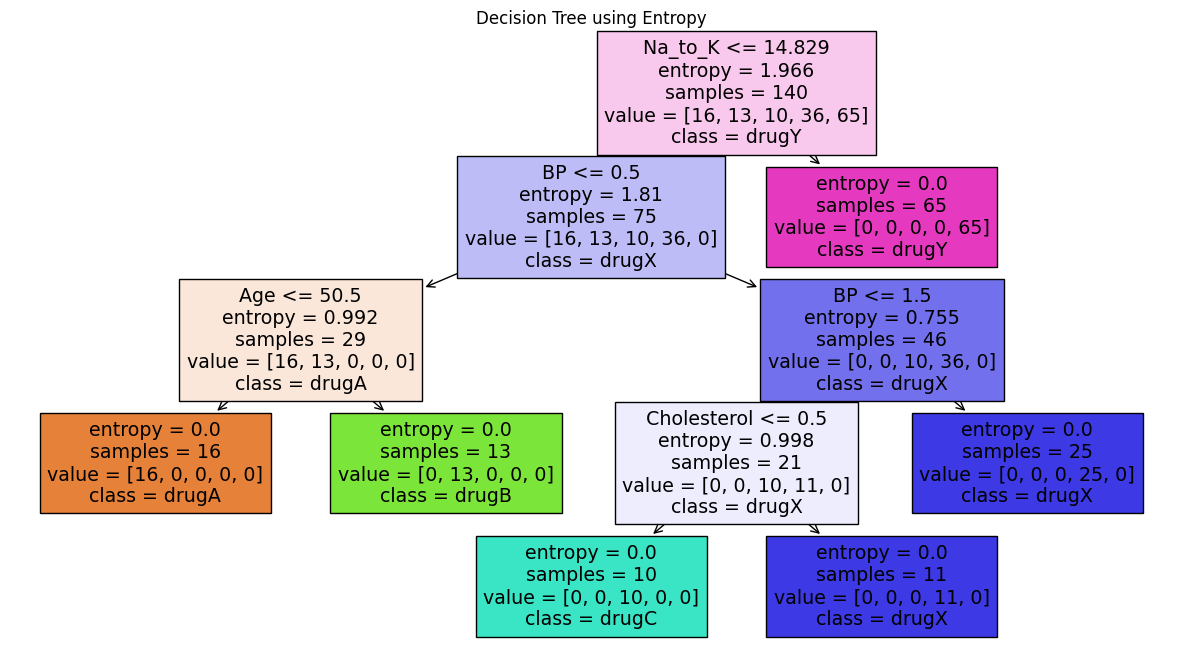

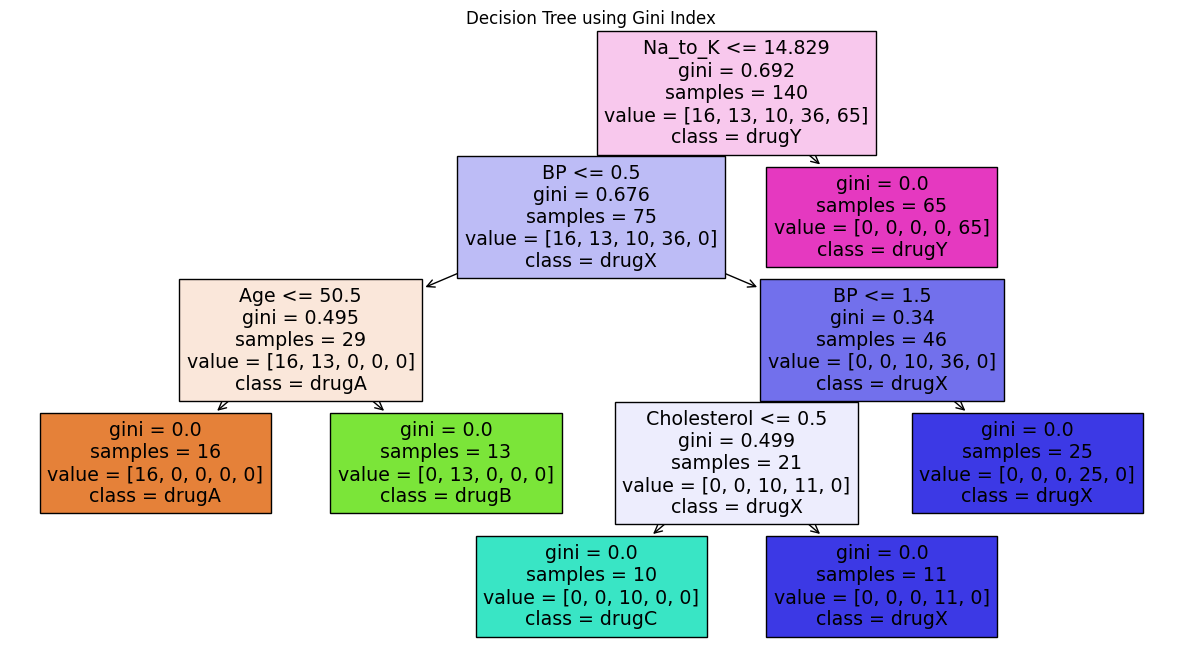

In [29]:
# Plot Entropy Tree
plt.figure(figsize=(15, 8))
plot_tree(clf_entropy, feature_names=X.columns, class_names=label_encoders['Drug'].classes_, filled=True)
plt.title("Decision Tree using Entropy")
plt.show()

# Plot Gini Tree
plt.figure(figsize=(15, 8))
plot_tree(clf_gini, feature_names=X.columns, class_names=label_encoders['Drug'].classes_, filled=True)
plt.title("Decision Tree using Gini Index")
plt.show()


In [30]:
from sklearn.metrics import accuracy_score

print("Entropy Accuracy:", accuracy_score(y_test, clf_entropy.predict(X_test)))
print("Gini Accuracy:", accuracy_score(y_test, clf_gini.predict(X_test)))

Entropy Accuracy: 1.0
Gini Accuracy: 1.0
